## Compare LucasKAN's ability in function interpolation with MLP

In [45]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from LucasKANLayer import LucasKANLayer

In [46]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    return y

In [47]:
# Define MLP and LucasKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.layers(x)


class LucasKAN(nn.Module):
    def __init__(self):
        super(LucasKAN, self).__init__()
        self.lucaskan1 = LucasKANLayer(1, 6, 8)
        self.lucaskan2 = LucasKANLayer(6, 8, 8)
        self.lucaskan3 = LucasKANLayer(8, 1, 5)

        # Regularization layers
        self.dropout = nn.Dropout(0.07)  # Dropout layer with p=0.1

    def forward(self, x):
        x = self.lucaskan1(x)
        x = self.dropout(x)  # Apply dropout after the first layer
        x = self.lucaskan2(x)
        x = self.lucaskan3(x)
        return x

Epoch 1/50000, LucasKAN Loss: 0.6422, MLP Loss: 0.6711
Epoch 101/50000, LucasKAN Loss: 0.4817, MLP Loss: 0.2300
Epoch 201/50000, LucasKAN Loss: 0.4763, MLP Loss: 0.1971
Epoch 301/50000, LucasKAN Loss: 0.4109, MLP Loss: 0.1949
Epoch 401/50000, LucasKAN Loss: 0.4066, MLP Loss: 0.1934
Epoch 501/50000, LucasKAN Loss: 0.4668, MLP Loss: 0.1921
Epoch 601/50000, LucasKAN Loss: 0.4133, MLP Loss: 0.1909
Epoch 701/50000, LucasKAN Loss: 0.3880, MLP Loss: 0.1897
Epoch 801/50000, LucasKAN Loss: 0.3295, MLP Loss: 0.1882
Epoch 901/50000, LucasKAN Loss: 0.3765, MLP Loss: 0.1874
Epoch 1001/50000, LucasKAN Loss: 0.2668, MLP Loss: 0.1883
Epoch 1101/50000, LucasKAN Loss: 0.4545, MLP Loss: 0.1862
Epoch 1201/50000, LucasKAN Loss: 0.5619, MLP Loss: 0.1862
Epoch 1301/50000, LucasKAN Loss: 0.2877, MLP Loss: 0.1856
Epoch 1401/50000, LucasKAN Loss: 0.2878, MLP Loss: 0.1850
Epoch 1501/50000, LucasKAN Loss: 0.4951, MLP Loss: 0.1842
Epoch 1601/50000, LucasKAN Loss: 0.4444, MLP Loss: 0.1834
Epoch 1701/50000, LucasKAN

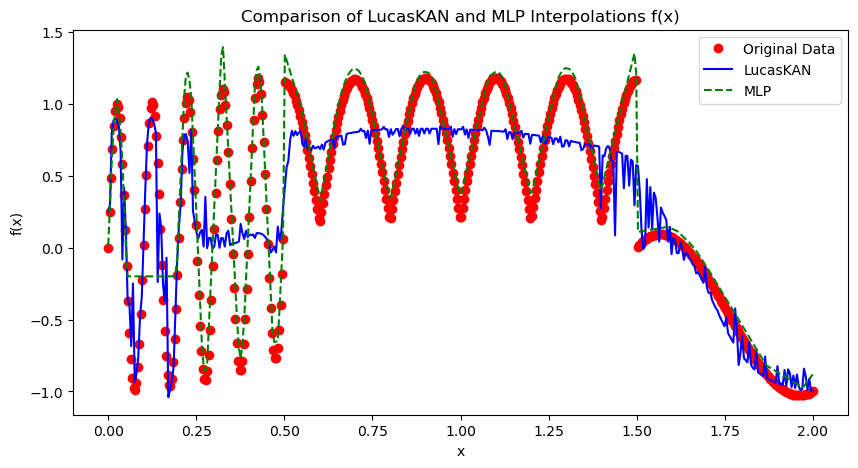

In [48]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
lucas_model = LucasKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_lucas = torch.optim.Adam(lucas_model.parameters(), lr=0.005)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

# Train the models
epochs = 50000
for epoch in range(epochs):
    optimizer_lucas.zero_grad()
    outputs_lucas = lucas_model(x_train)
    loss_lucas = criterion(outputs_lucas, y_train)
    loss_lucas.backward()
    optimizer_lucas.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, LucasKAN Loss: {loss_lucas.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_lucas = lucas_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_lucas.numpy(), 'b-', label='LucasKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of LucasKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()